In [ ]:
##############################
# CarND-Vehicle-Detection-P5 #
##############################

# Author: Michael
# 153792051@qq.com
# fengjihua@live.com


# Pipeline:
# 1.Histogram of Oriented Gradients (HOG)
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
# Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
# Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

# 2.Sliding Window Search
# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

# 3.Video Implementation
# Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
# Estimate a bounding box for vehicles detected

In [2]:
# Import Library
import os
import time
import numpy as np
import cv2
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.feature import hog
from scipy.ndimage.measurements import label
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


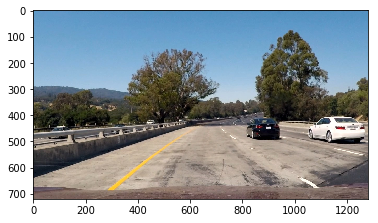

In [3]:
# Process test images
img_file = './test_images/test1.jpg'

img_original = plt.imread(img_file)
# plt.figure(figsize=(18,10))
plt.imshow(img_original)
plt.show()

In [4]:
######################
# Get Color Features #
######################
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
####################
# Get Hog Features #
####################
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, 
                                  feature_vector=feature_vec, 
                                  block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, 
                       feature_vector=feature_vec, 
                       block_norm="L2-Hys")
        return features

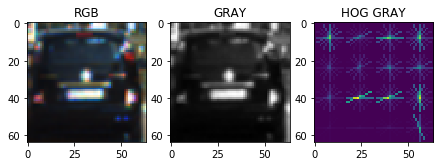

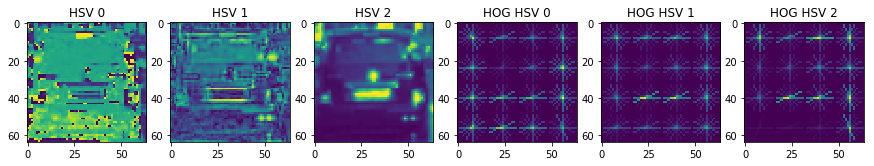

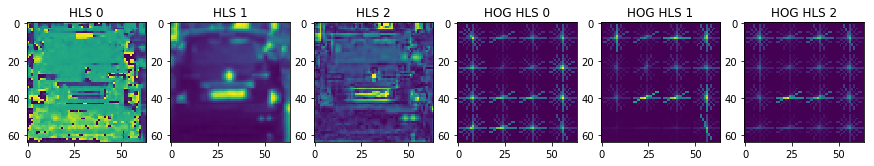

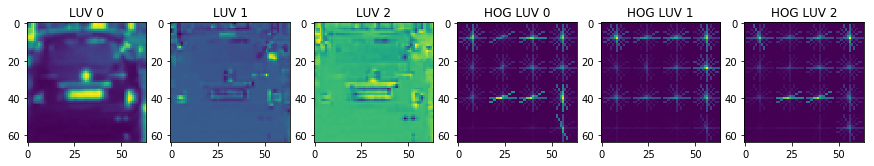

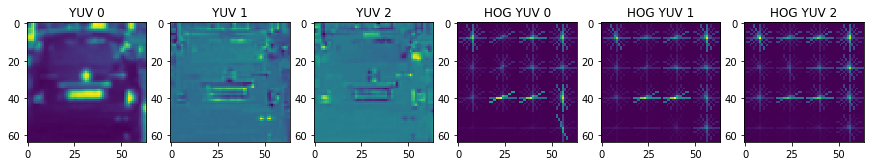

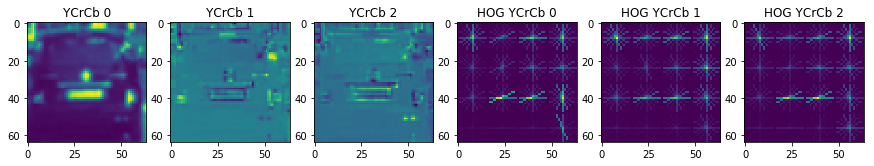

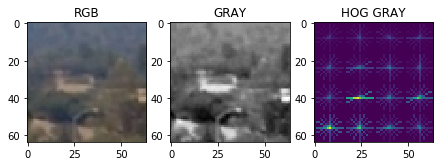

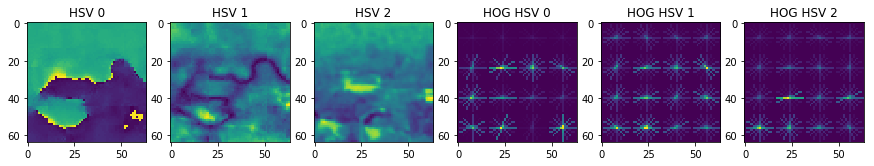

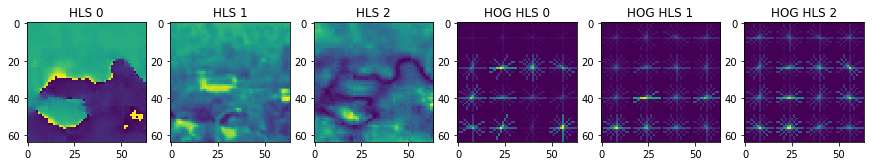

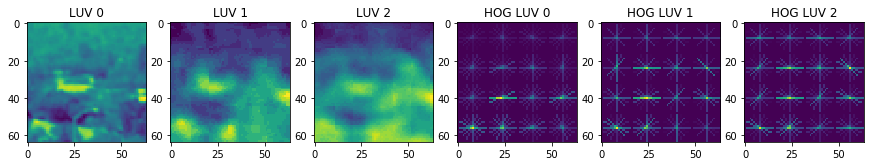

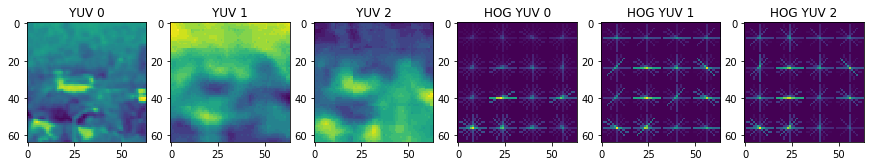

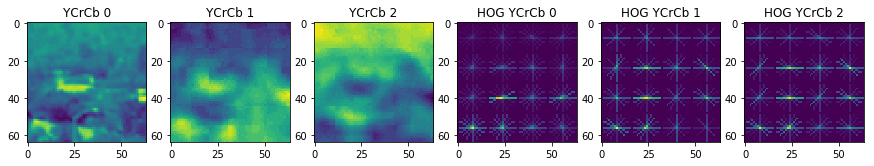

In [6]:
def color_analyze(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    orient = 8
    pix_per_cell = 16
    cell_per_block = 2
    
    _, hog_gray = get_hog_features(img_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_hsv_0 = get_hog_features(img_hsv[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_hsv_1 = get_hog_features(img_hsv[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_hsv_2 = get_hog_features(img_hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_hls_0 = get_hog_features(img_hls[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_hls_1 = get_hog_features(img_hls[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_hls_2 = get_hog_features(img_hls[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_luv_0 = get_hog_features(img_luv[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_luv_1 = get_hog_features(img_luv[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_luv_2 = get_hog_features(img_luv[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_yuv_0 = get_hog_features(img_yuv[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_yuv_1 = get_hog_features(img_yuv[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_yuv_2 = get_hog_features(img_yuv[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_ycb_0 = get_hog_features(img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_ycb_1 = get_hog_features(img_ycrcb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    _, hog_ycb_2 = get_hog_features(img_ycrcb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    
    plt.figure(figsize=(15,15))
    plt.subplot(161)
    plt.title('RGB')
    plt.imshow(img_rgb)
    plt.subplot(162)
    plt.title('GRAY')
    plt.imshow(img_gray, cmap='gray')
    plt.subplot(163)
    plt.title('HOG GRAY')
    plt.imshow(hog_gray)
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.subplot(161)
    plt.title('HSV 0')
    plt.imshow(img_hsv[:,:,0])
    plt.subplot(162)
    plt.title('HSV 1')
    plt.imshow(img_hsv[:,:,1])
    plt.subplot(163)
    plt.title('HSV 2')
    plt.imshow(img_hsv[:,:,2])
    plt.subplot(164)
    plt.title('HOG HSV 0')
    plt.imshow(hog_hsv_0)
    plt.subplot(165)
    plt.title('HOG HSV 1')
    plt.imshow(hog_hsv_1)
    plt.subplot(166)
    plt.title('HOG HSV 2')
    plt.imshow(hog_hsv_2)
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.subplot(161)
    plt.title('HLS 0')
    plt.imshow(img_hls[:,:,0])
    plt.subplot(162)
    plt.title('HLS 1')
    plt.imshow(img_hls[:,:,1])
    plt.subplot(163)
    plt.title('HLS 2')
    plt.imshow(img_hls[:,:,2])
    plt.subplot(164)
    plt.title('HOG HLS 0')
    plt.imshow(hog_hls_0)
    plt.subplot(165)
    plt.title('HOG HLS 1')
    plt.imshow(hog_hls_1)
    plt.subplot(166)
    plt.title('HOG HLS 2')
    plt.imshow(hog_hls_2)
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.subplot(161)
    plt.title('LUV 0')
    plt.imshow(img_luv[:,:,0])
    plt.subplot(162)
    plt.title('LUV 1')
    plt.imshow(img_luv[:,:,1])
    plt.subplot(163)
    plt.title('LUV 2')
    plt.imshow(img_luv[:,:,2])
    plt.subplot(164)
    plt.title('HOG LUV 0')
    plt.imshow(hog_luv_0)
    plt.subplot(165)
    plt.title('HOG LUV 1')
    plt.imshow(hog_luv_1)
    plt.subplot(166)
    plt.title('HOG LUV 2')
    plt.imshow(hog_luv_2)
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.subplot(161)
    plt.title('YUV 0')
    plt.imshow(img_yuv[:,:,0])
    plt.subplot(162)
    plt.title('YUV 1')
    plt.imshow(img_yuv[:,:,1])
    plt.subplot(163)
    plt.title('YUV 2')
    plt.imshow(img_yuv[:,:,2])
    plt.subplot(164)
    plt.title('HOG YUV 0')
    plt.imshow(hog_yuv_0)
    plt.subplot(165)
    plt.title('HOG YUV 1')
    plt.imshow(hog_yuv_1)
    plt.subplot(166)
    plt.title('HOG YUV 2')
    plt.imshow(hog_yuv_2)
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.subplot(161)
    plt.title('YCrCb 0')
    plt.imshow(img_ycrcb[:,:,0])
    plt.subplot(162)
    plt.title('YCrCb 1')
    plt.imshow(img_ycrcb[:,:,1])
    plt.subplot(163)
    plt.title('YCrCb 2')
    plt.imshow(img_ycrcb[:,:,2])
    plt.subplot(164)
    plt.title('HOG YCrCb 0')
    plt.imshow(hog_ycb_0)
    plt.subplot(165)
    plt.title('HOG YCrCb 1')
    plt.imshow(hog_ycb_1)
    plt.subplot(166)
    plt.title('HOG YCrCb 2')
    plt.imshow(hog_ycb_2)
    plt.show()
    

images_cars = glob.glob('./data/vehicles/KITTI_extracted/*')
images_notcars = glob.glob('./data/non-vehicles/*/*')
    
car_ind = np.random.randint(0, len(images_cars[0]))
notcar_ind = np.random.randint(0, len(images_notcars[1]))

img_car = cv2.imread(images_cars[car_ind])
img_notcar = cv2.imread(images_notcars[car_ind])

color_analyze(img_car)
color_analyze(img_notcar)

In [7]:
# Define a function to extract features from a single image window
# just for a single image rather than list of images
def single_img_features(img, 
                        color_space='RGB',
                        spatial_size=(32, 32),
                        hist_bins=32,
                        orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = []
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, 
                                            orient, 
                                            pix_per_cell,
                                            cell_per_block, 
                                            vis=False, 
                                            feature_vec=True)
        elif hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                     orient, 
                                                     pix_per_cell, 
                                                     cell_per_block, 
                                                     vis=False, 
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, 
                                            pix_per_cell, 
                                            cell_per_block, 
                                            vis=False, 
                                            feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def single_mix_feature(img,
                       orient=9,
                       pix_per_cell=8,
                       cell_per_block=2):
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    hog_gray = get_hog_features(img_gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_hsv_1 = get_hog_features(img_hsv[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_hsv_2 = get_hog_features(img_hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_ycrcb_0 = get_hog_features(img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
#     return hog_gray
#     return np.ravel([hog_hsv_1, hog_hsv_2, hog_gray])
    return np.ravel([hog_hsv_1, hog_hsv_2])

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs,
                     color_space='RGB',
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     orient=9, 
                     pix_per_cell=8,
                     cell_per_block=2, 
                     hog_channel=0,
                     spatial_feat=True,
                     hist_feat=True, 
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
#         img = mpimg.imread(file)
        img = cv2.imread(file)
#         img_features = single_img_features(img,
#                                            color_space=color_space, 
#                                            spatial_size=spatial_size, 
#                                            hist_bins=hist_bins, 
#                                            orient=orient, 
#                                            pix_per_cell=pix_per_cell, 
#                                            cell_per_block=cell_per_block, 
#                                            hog_channel=hog_channel,
#                                            spatial_feat=spatial_feat, 
#                                            hist_feat=hist_feat, 
#                                            hog_feat=hog_feat)
        img_features = single_mix_feature(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
        features.append(img_features)
    # Return list of feature vectors
    return features

In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, 
                   windows,
                   clf, 
                   scaler, 
                   color_space='RGB', 
                   spatial_size=(32, 32), 
                   hist_bins=32, 
                   hist_range=(0, 256), 
                   orient=9, 
                   pix_per_cell=8,
                   cell_per_block=2, 
                   hog_channel=0,
                   spatial_feat=True, 
                   hist_feat=True, 
                   hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    i = 0
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, 
#                                        color_space=color_space, 
#                                        spatial_size=spatial_size, 
#                                        hist_bins=hist_bins, 
#                                        orient=orient, 
#                                        pix_per_cell=pix_per_cell, 
#                                        cell_per_block=cell_per_block, 
#                                        hog_channel=hog_channel,
#                                        spatial_feat=spatial_feat, 
#                                        hist_feat=hist_feat, 
#                                        hog_feat=hog_feat)
        features = single_mix_feature(test_img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
#         test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
#         features = get_hog_features(test_img_gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        if i == 0:    
#             print(type(features), features.shape)
            i += 1
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def search_nn_windows(img, windows_all_size, clf):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        #4) Extract features for that window using single_img_features()
        #5) Scale extracted features to be fed to classifier
        #6) Predict using your classifier
        x = test_img.reshape((1,) + test_img.shape)
        prediction = np.argmax(clf.predict(x)[0])
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [9]:
######################
# Draw Slide Windows #
######################
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        x1 = bbox[0][0]
        x2 = bbox[1][0]
        width = int(x2-x1)
#         print(width)
        color = (255, 255, 255)
        if width == 64:
            color = (255, 0, 0)
        if width == 96:
            color = (0, 255, 0)
        if width == 128:
            color = (0, 0, 255)
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# img_height = int(img_original.shape[0]//2)
# windows = slide_window(img_original, x_start_stop=[None, None], y_start_stop=[img_height, None], 
#                     xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
# window_img = draw_boxes(img_original, windows, color=(0, 0, 255), thick=6)                    
# plt.imshow(window_img)
# plt.show()

In [10]:
###########
# Heatmap #
###########
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
#     heatmap[heatmap <= threshold] = 0
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

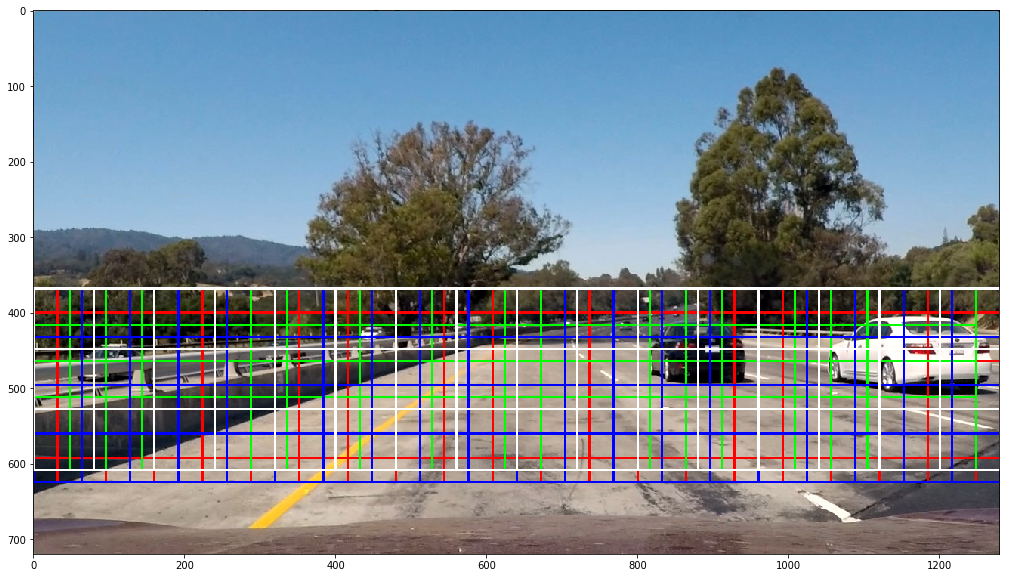

In [11]:
# prepare slide windows
y_start = 368
y_stop = y_start + 32 * 10
# xy_window = [(64,64), (96,96), (128,128), (256,256)]
# y_start_stop = [[y_start, y_start+32*8], [y_start, y_start+32*8], [y_start, y_stop], [y_start, y_stop]]
xy_window = [(64,64), (96,96), (128,128), (160,160)]
y_start_stop = [[y_start, y_start+32*8], [y_start, y_start+32*8], [y_start, y_start+32*8], [y_start, y_start+32*8]]
windows_all_size = []
for i in range(len(xy_window)):
    windows = slide_window(img_original, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                    xy_window=xy_window[i], xy_overlap=(0.5, 0.5))
    for window in windows:
        windows_all_size.append(window)
        
window_img = draw_boxes(img_original, windows_all_size, color=(0, 0, 255), thick=2)                    
plt.figure(figsize=(18,10))
plt.imshow(window_img)
plt.show()

In [ ]:
#####################
# Data Augmentation #
#####################
# images_cars = glob.glob('./data/vehicles/*/*')
# images_notcars = glob.glob('./data/non-vehicles/*/*')
images_cars = glob.glob('./data/aug/cars4/*')
# images_notcars = glob.glob('./data/aug/notcars12/*')
        
# augment cars
cars_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2)
#     zoom_range=[0.8,1.2])

# augment notcars
notcars_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='reflect')


for image in images_cars:
    x = plt.imread(image)
    x = x.reshape((1,) + x.shape)
    
    i = 0
    for batch in cars_datagen.flow(x, batch_size=10, save_to_dir='./data/aug/cars4', save_prefix='cars', save_format='jpg'):
        i += 1
        if i == 10:
            break;
    
# for image in images_notcars:
#     x = plt.imread(image)
#     x = x.reshape((1,) + x.shape)
    
#     i = 0
#     for batch in notcars_datagen.flow(x, batch_size=20, save_to_dir='./data/aug/notcars12', save_prefix='not', save_format='jpg'):
#         i += 1
#         if i == 20:
#             break;

In [12]:
#######################
# Classifier Training #
#######################
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

def preprocess():
    show_plot = False
    
    list_cars = []
    list_notcars = []
    
    images_cars = glob.glob('./data/vehicles/*/*')
    images_notcars = glob.glob('./data/non-vehicles/*/*')
    for image in images_cars:
        list_cars.append(image)
    for image in images_notcars:
        list_notcars.append(image)
    
#     aug_cars = glob.glob('./data/aug/cars/*.jpg')
#     aug_notcars = glob.glob('./data/aug/notcars*/*.jpg')
#     for image in aug_cars:
#         list_cars.append(image)
#     for image in aug_notcars:
#         list_notcars.append(image)
        
    data_info = {}
    data_info["n_cars"] = len(list_cars)
    data_info["n_notcars"] = len(list_notcars)
    example_img = cv2.imread(list_cars[0])
    data_info["image_shape"] = example_img.shape
    data_info["data_type"] = example_img.dtype
        
    print('cars:',data_info["n_cars"],', notcars:', data_info["n_notcars"], ', shape:', data_info["image_shape"], data_info["data_type"])

    t = time.time()
    car_features = []
    notcar_features = []
#     for img_file in list_cars:
#         img_gray = cv2.imread(img_file, 0)
#         features = get_hog_features(img_gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         car_features.append(features)
#     for img_file in list_notcars:
#         img_gray = cv2.imread(img_file, 0)
#         features = get_hog_features(img_gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         notcar_features.append(features)

    car_features = extract_features(list_cars,
                                    color_space=color_space, 
                                    spatial_size=spatial_size, 
                                    hist_bins=hist_bins, 
                                    orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, 
                                    spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat,
                                    hog_feat=hog_feat)
    notcar_features = extract_features(list_notcars, 
                                       color_space=color_space, 
                                       spatial_size=spatial_size, 
                                       hist_bins=hist_bins, 
                                       orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, 
                                       hog_feat=hog_feat)
    print(type(car_features), type(car_features[0]), car_features[0].shape, notcar_features[0].shape)
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to extract features...')
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print(X.shape, scaled_X.shape)
    print(len(car_features), len(notcar_features))

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=50)
    print('Feature vector length:', len(X_train[0]))
    
#     print(X_scaler)
    return X_train, X_test, y_train, y_test, (pix_per_cell, cell_per_block, orient, X_scaler)

def train(X_train, X_test, y_train, y_test, hog_params):    
    clf = LinearSVC()
#     clf = SVC()
#     svr = SVC()
#     parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} 
#     clf = GridSearchCV(svr, parameters)
    
    # Check the training time for the SVC
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
#     print('SVC best params:', clf.best_params_)
    
    # Check the score of the SVC
    score = round(clf.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', score)
    
    # Check the prediction time for a single sample
    t = time.time()
    n_predict = 10
    print('SVC predicts: ', clf.predict(X_test[0:n_predict]))
    print('SVC   labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    # Save the model
    pix_per_cell = hog_params[0]
    cell_per_block = hog_params[1]
    orient = hog_params[2]
    X_scaler = hog_params[3]
    
    data_model = {}
    data_model['pix_per_cell'] = pix_per_cell
    data_model['cell_per_block'] = cell_per_block
    data_model['orient'] = orient
    data_model['X_scaler'] = X_scaler
    data_model['clf'] = clf
    data_model['color_space'] = color_space
    data_model['hog_channel'] = hog_channel
    data_model['spatial_size'] = spatial_size
    data_model['hist_bins'] = hist_bins
    data_model['spatial_feat'] = spatial_feat
    data_model['hist_feat'] = hist_feat
    data_model['hog_feat'] = hog_feat
    
    with open('./svc_{}_{}_{}_{}_{}.pkl'.format(score, color_space, pix_per_cell, cell_per_block, orient), 'wb') as file:
        pickle.dump(data_model, file, True)
    print('SVC Saved...')
    
    return clf

#########
# Train #
#########
X_train, X_test, y_train, y_test, hog_params = preprocess()
clf = train(X_train, X_test, y_train, y_test, hog_params)

cars: 10097 , notcars: 60278 , shape: (64, 64, 3) uint8
<class 'list'> <class 'numpy.ndarray'> (576,) (576,)
298.43286 Seconds to extract features...
(70375, 576) (70375, 576)
10097 60278
Feature vector length: 576
33.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9717
SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
SVC   labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00151 Seconds to predict 10 labels with SVC
SVC Saved...


In [12]:
##############
# Checkpoint #
##############
def load_svm_model():
    data_model = {}
#     model = './svc_0.9459_16_2_8.pkl' # GRAY - hog - correct
#     model = './svc_0.9443_16_2_8.pkl' # GRAY - hog - correct
#     model = './svc_0.9428_16_2_8.pkl' # GRAY - hog - correct - good
#     model = './svc_0.982_16_2_8.pkl' # YCrCb - hog - correct - not good
#     model = './svc_0.9702_16_2_8.pkl' # HSV - hog - best
#     model = './svc_0.9887_16_2_8.pkl' # HSV - hist+hog - correct - not good
#     model = './svc_0.973_16_2_8.pkl' # HSV+GRAY - good
#     model = './svc_0.953_16_2_8.pkl' # mix: GRAY+HSV2 - not good
#     model = './svc_0.9426_16_2_8.pkl' # HSV2 - good
#     model = './svc_0.9164_16_2_8.pkl' # HSV0 - not so good, like shadow and dark
#     model = './svc_0.924_16_2_8.pkl' # HSV1 - good
#     model = './svc_0.9654_16_2_8.pkl' # mix: HSV1+HSV2  best
#     model = './svc_0.9698_16_2_8.pkl' # augment mix: HSV1+HSV2
#     model = './svc_0.9741_16_2_8.pkl' # augment mix: HSV1+HSV2+GRAY not so good
#     model = './svc_0.9508_16_2_8.pkl' # augment Gray not so goood
#     model = './svc_0.9474_16_1_8.pkl' # mix: HSV1+HSV2  good
#     model = './svc_0.9845_HSV_16_2_8.pkl' # mix
#     model = './svc_0.9794_HLS_16_2_8.pkl'
#     model = './models1/svc_0.9696_HSV_16_2_9_ALL_False_False_True.p'
#     model = './models1/svc_0.9696_HSV_16_2_8_ALL_False_False_True.p' # best
#     model = './svc_0.9758_HSV_16_2_8.pkl' #best augment
#     model = './models1/svc_0.9651_HSV_16_1_8_ALL_False_False_True.p'
#     model = './models1/svc_0.9648_HSV_16_1_9_ALL_False_False_True.p'
#     model = './models1/svc_0.9671_HLS_16_2_8_ALL_False_False_True.p'
#     model = './models1/svc_0.9668_HLS_16_2_9_ALL_False_False_True.p'  # best
#     model = './models1/svc_0.9451_GRAY_16_2_8_0_False_False_True.p' # good
#     model = './models1/svc_0.9448_HLS_16_2_9_1_False_False_True.p'
#     model = './models1/svc_0.9437_HSV_16_2_9_2_False_False_True.p' # good
#     model = './models1/svc_0.9434_HSV_16_2_8_2_False_False_True.p'
#     model = './models2/svc_0.9845_HSV_16_2_9_ALL_True_True_True.p' # not good
#     model = './models2/svc_0.9845_HSV_16_2_8_ALL_True_True_True.p' # not good
#     model = './models2/svc_0.9794_HLS_16_2_8_ALL_True_True_True.p' # not good
#     model = './models2/svc_0.9792_HLS_16_2_9_ALL_True_True_True.p' # not good

#     model = './svc_0.9654_HSV_16_2_8.pkl' #mix:HSV1+HSV2 best
    model = './svc_0.9717_HSV_16_2_8.pkl' #
    

    with open(model, 'rb') as file:
        data_model = pickle.load(file)

    return data_model
# model = load_svm_model()

In [13]:
def load_nn_model():
    model = load_model('./model.h5')
    return model

In [14]:
############
# Pipeline #
############

# 1.Classifier and params ready
model = load_svm_model()
# model = load_nn_model()

# 2.windows_all_size ready

frame = 0
heatmaps = list()
heatmap_limit = 20
propability = 4/10

def pipeline_reset():
    global frame, heatmap_limit, heatmaps
    frame = 0
    heatmaps = list()

def pipeline(img):
    global model, windows_all_size, frame, heatmap_limit, heatmaps
        
    frame += 1
    
    # 1.prepare classifier and params
    pix_per_cell = int(model['pix_per_cell'])
    cell_per_block = int(model['cell_per_block'])
    orient = int(model['orient'])
    X_scaler = model['X_scaler']
    clf = model['clf']
    color_space = model['color_space']
    hog_channel = model['hog_channel']
    spatial_size = model['spatial_size']
    hist_bins = model['hist_bins']
    spatial_feat = model['spatial_feat']
    hist_feat = model['hist_feat']
    hog_feat = model['hog_feat']
#     print(clf)
    
    # 2.Search vehicles
    hot_windows = search_windows(img, 
                                 windows_all_size, 
                                 clf, 
                                 X_scaler,
                                 color_space=color_space,
                                 spatial_size=spatial_size, 
                                 hist_bins=hist_bins, 
                                 orient=orient, 
                                 pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, 
                                 spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, 
                                 hog_feat=hog_feat)

#     clf = model
#     hot_windows = search_nn_windows(img, windows_all_size, clf)
    
    # 3.Heatmap and label
    img_heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    is_video = False
    ######################
    # For Single Picture #
    ######################
    if is_video == False:
        debug = True
        # Add heat to each box in box list
        img_heat = add_heat(img_heat, hot_windows)
        max_heat = int(np.max(img_heat))
        threshold_heat = max_heat * propability
        print(max_heat)

        # Apply threshold to help remove false positives
        img_heat = apply_threshold(img_heat, np.max([2,threshold_heat]))

        # Visualize the heatmap when displaying    
        heatmap = np.clip(img_heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    ###################
    # For Video Frame #
    ###################
    if is_video == True:
        debug = False
        img_heat = add_heat(img_heat, hot_windows)
        heatmap = np.clip(img_heat, 0, 255)
        heatmaps.append(heatmap)
        if len(heatmaps) > heatmap_limit:
            del heatmaps[0]

        heatmap_sum = np.sum(heatmaps, axis=0)
        max_frame = int(np.max(heatmap))
        max_sum = int(np.max(heatmap_sum))
        threshold_max = np.max([30,max_sum*propability])

        heatmap_final = np.copy(heatmap_sum)
        heatmap_final[heatmap_sum < threshold_max] = 0
    # #     heatmap_final[(heatmap_sum < threshold_max) | (heatmap == 0)] = 0
#         mpimg.imsave("./heat_images/21_{:0>2}_0.jpg".format(frame), img)
#         mpimg.imsave("./heat_images/21_{:0>2}_1_{}.jpg".format(frame,max_frame), heatmap)
#         mpimg.imsave("./heat_images/21_{:0>2}_2_{}.jpg".format(frame,max_sum), heatmap_sum)
#         mpimg.imsave("./heat_images/21_{:0>2}_3_{}.jpg".format(frame,max_sum), heatmap_final)

        if frame > heatmap_limit:
            labels = label(heatmap_final)
            draw_img = draw_labeled_bboxes(np.copy(img), labels)
#             mpimg.imsave("./heat_images/21_{:0>2}_4_{}.jpg".format(frame,labels[1]), draw_img)
        else:
            draw_img = img
    
    if debug:
        print('Find hot windows:', len(hot_windows))
        window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=2)
        plt.figure(figsize=(18,10))
        plt.subplot(121)
        plt.title('Hot windows')
        plt.imshow(window_img)
        plt.subplot(122)
        plt.title('Car Positions')
        plt.imshow(draw_img)
        plt.show()

        plt.figure(figsize=(18,10))
        plt.subplot(121)
        plt.title('Heat Map')
        plt.imshow(heatmap, cmap='hot')
        plt.subplot(122)
        plt.title('Labels')
        plt.imshow(labels[0], cmap='gray')
        plt.show()
    
    return draw_img

Process  ./test_images/test1.jpg
4
Find hot windows: 14


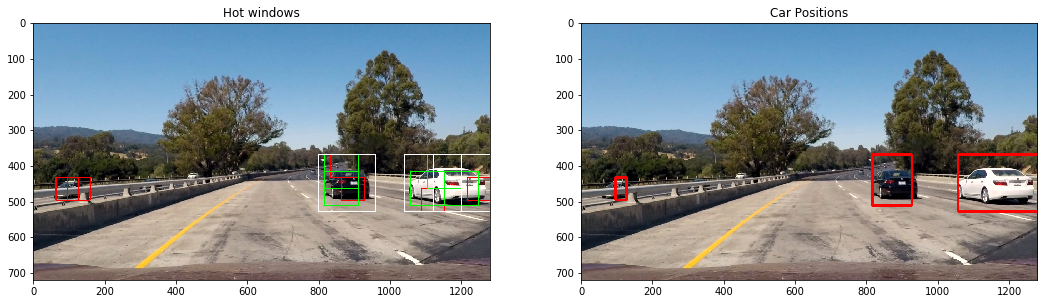

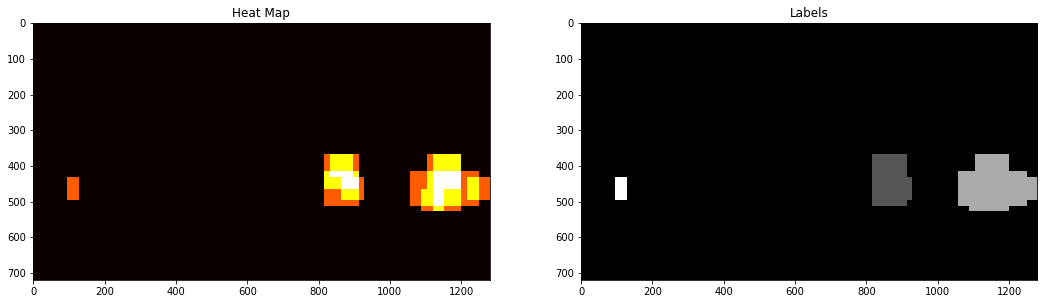

Process  ./test_images/test2.jpg
1
Find hot windows: 2


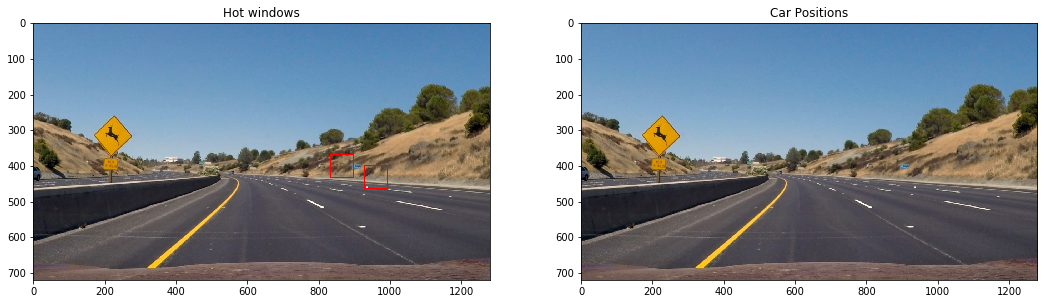

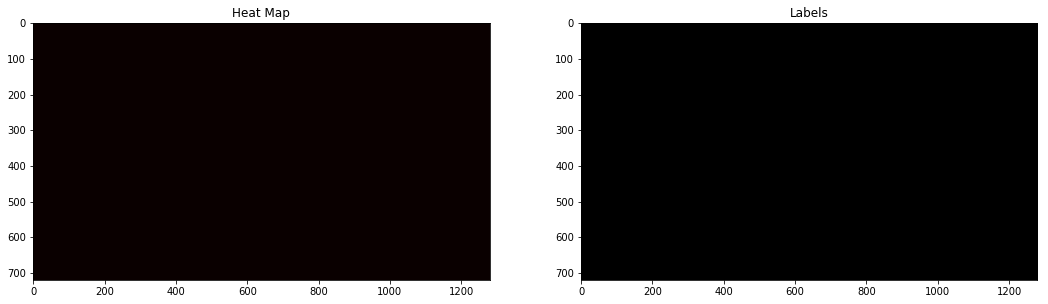

Process  ./test_images/test3.jpg
2
Find hot windows: 2


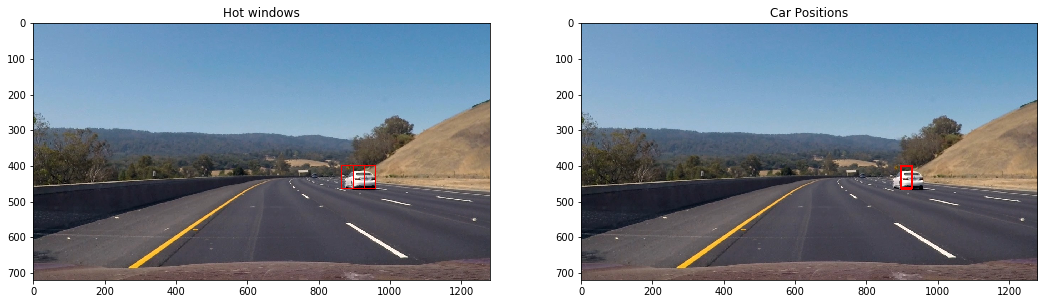

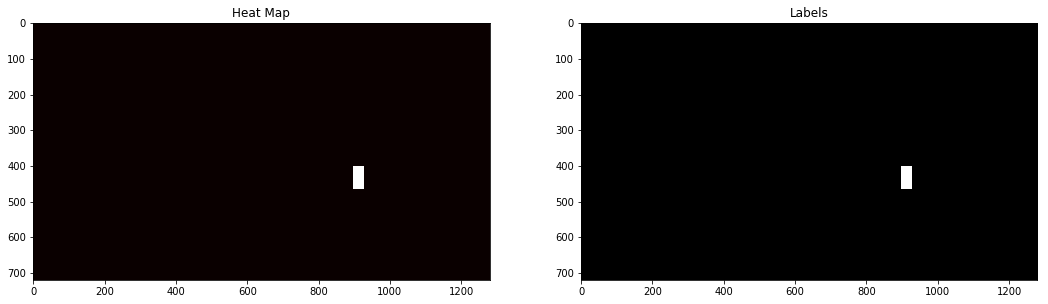

Process  ./test_images/test4.jpg
7
Find hot windows: 14


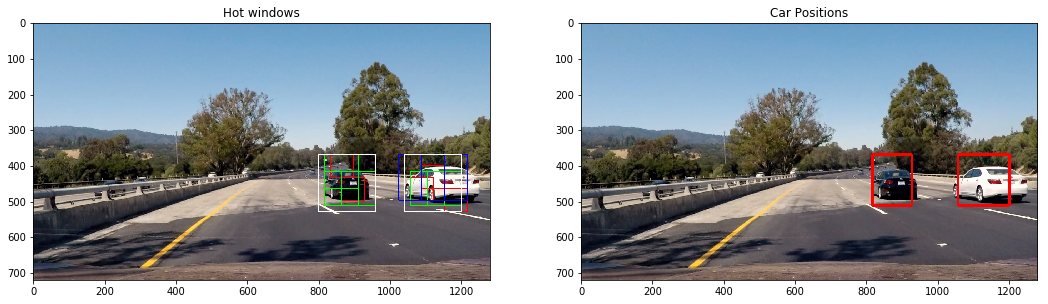

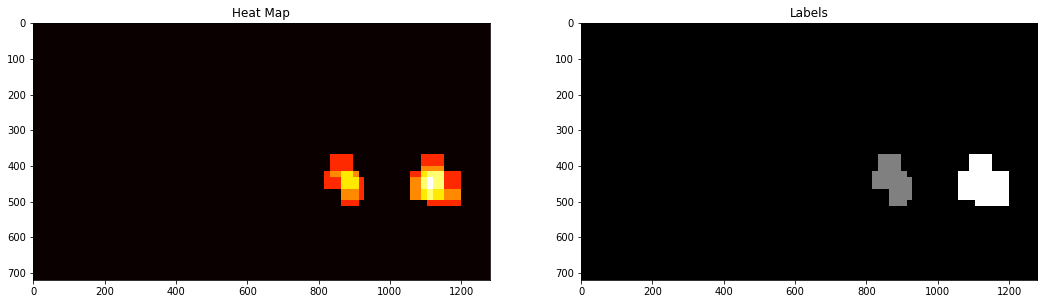

Process  ./test_images/test5.jpg
5
Find hot windows: 14


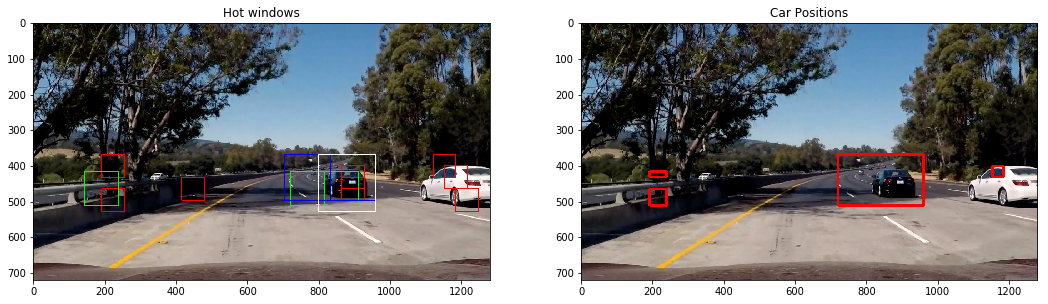

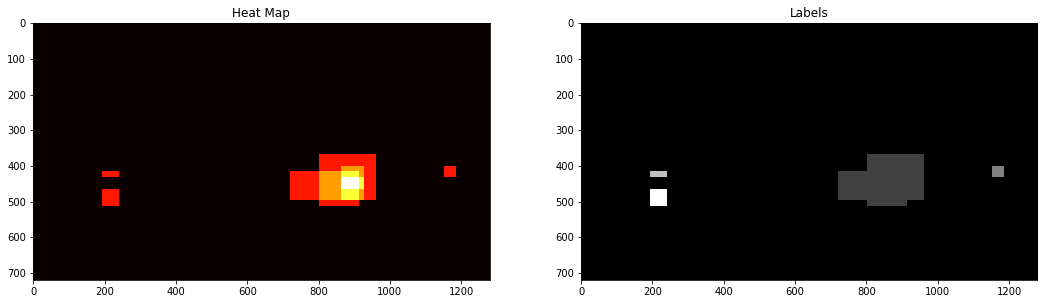

Process  ./test_images/test6.jpg
4
Find hot windows: 9


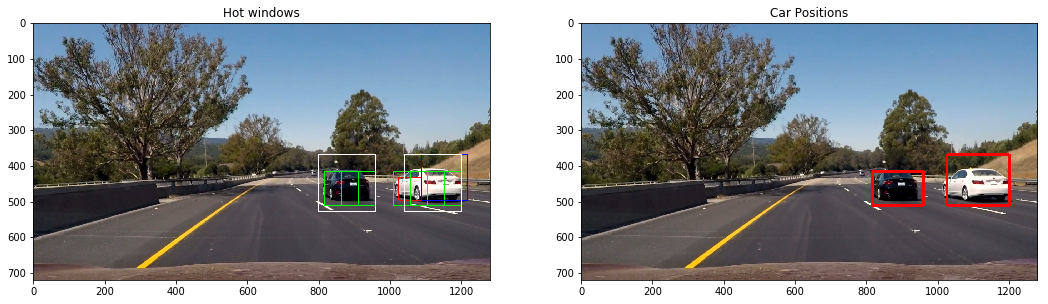

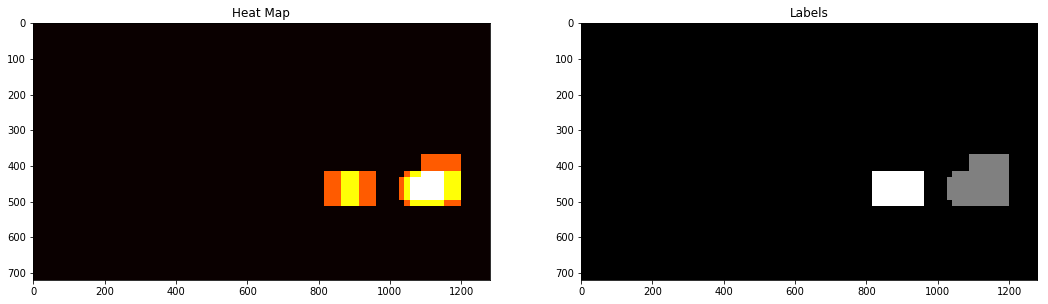

In [16]:
###### Process test images
images = glob.glob('./test_images/*.jpg')
# images = glob.glob('./test_images/test1.jpg')
    
for img_file in images:
    print('Process ',img_file)
    img_name, img_ext = os.path.splitext(img_file.split('/')[-1])
    img_original = mpimg.imread(img_file)
    
    pipeline_reset()
    img_final = pipeline(img_original)
    mpimg.imsave("./output_images/{}_final.jpg".format(img_name), img_final)


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
#############################
# Process project_video.mp4 #
#############################

# reset parameter
pipeline_reset()

white_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("./project_video.mp4").subclip(19,25)
clip1 = VideoFileClip("./project_video.mp4")
# clip1.save_frame("./fram/00.jpeg")
# clip1.save_frame("./frame/22_1.jpg", t=22.5)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, progress_bar=True)
print('project_video_output.mp4 finished!')

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [20:15<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 18min 44s, sys: 1min 25s, total: 20min 10s
Wall time: 20min 16s
project_video_output.mp4 finished!
